In [9]:
from dataclasses import dataclass
from typing import List, Optional
import math
import random

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageChops
import numpy as np

In [28]:
@dataclass
class Tile:
    x_start: int
    x_end: int
    y_start: int
    y_end: int

    @property
    def width(self) -> int:
        """Return the width of the tile."""
        return self.x_end - self.x_start

    @property
    def height(self) -> int:
        """Return the height of the tile."""
        return self.y_end - self.y_start
    
    def get_image_tile(self, image: Image.Image) -> Image.Image:
        """
        Return the portion of the image that this tile represents.

        Args:
            image (Image.Image): The PIL Image from which the tile's portion will be cropped.

        Returns:
            Image.Image: A cropped PIL Image object representing the tile's portion of the image.
        """
        # Ensure the coordinates are within the image bounds
        # x_start = max(0, self.x_start)
        # x_end = min(image.width, self.x_end)
        # y_start = max(0, self.y_start)
        # y_end = min(image.height, self.y_end)
        
        # Crop the image using the tile's coordinates
        return image.crop((self.x_start, self.y_start, self.x_end, self.y_end))
    
    def create_blending_mask_tile_space(self, target_image, feather_radius: int):
        """
        Create a blending mask with feathered edges for the tile in tile space.

        Args:
            target_image (Image.Image): The target image to which the mask will be applied.
            feather_radius (int): The radius of the feathering effect (in pixels).

        Returns:
            Image.Image: A PIL Image object representing the blending mask with feathered edges.
        """

        mask = Image.new('L', (self.width, self.height), 0)
        draw = ImageDraw.Draw(mask)

        blend_x_start = feather_radius if self.x_start > 0 else 0
        blend_x_end = self.width-feather_radius if self.x_end < target_image.width else self.width
        blend_y_start = feather_radius if self.y_start > 0 else 0
        blend_y_end = self.height-feather_radius if self.y_end < target_image.height else self.height

        # Draw a white rectangle on the mask
        draw.rectangle([blend_x_start, blend_y_start, blend_x_end, blend_y_end], fill=255)

        # Apply Gaussian blur to create feathered edges
        if feather_radius > 0:
            mask = mask.filter(ImageFilter.GaussianBlur(feather_radius))

        return mask
    
    def create_blending_mask_target_image_space(self, target_image: Image.Image, feather_radius: int) -> Image.Image:
        """
        Generate a blending mask with feathered edges for the tile in target image space.

        Args:
            target_image (Image.Image): The image to which the tile belongs (used to get dimensions).
            feather_radius (int): The radius of the feathering effect (in pixels).

        Returns:
            Image.Image: A PIL Image object representing the blending mask with feathered edges.
        """
        # Create a blank mask with the same size as the tile
        mask = self.create_blending_mask_tile_space(target_image, feather_radius)

        # Create a new image of the same size as the original image and paste the mask onto it
        blending_mask = Image.new('L', (target_image.width, target_image.height), 0)
        blending_mask.paste(mask, (self.x_start, self.y_start))

        return blending_mask
    
    def compose_with_mask(self, target_image: Image.Image, tile_image: Image.Image, feather_radius) -> Image.Image:
        """
        Compose the tile_image onto the target_image using a blending mask with feathered edges.

        Args:
            target_image (Image.Image): The image onto which the tile will be blended.
            tile_image (Image.Image): The tile image to be blended.
            feather_radius (int): The radius of the feathering effect (in pixels).

        Returns:
            Image.Image: The resulting image after compositing.
        """

        # Extract the region from the target image
        region = target_image.crop((self.x_start, self.y_start, self.x_end, self.y_end))

        # Composite the images using the mask
        blending_mask = self.create_blending_mask_tile_space(target_image, feather_radius)
        blended_region = Image.composite(tile_image, region, blending_mask)

        # Paste the blended region back into the target image
        target_image.paste(blended_region, (self.x_start, self.y_start))

        return target_image
    
    def visualize_blending_mask(self, mask: Image.Image):
        """
        Visualize the blending mask by converting it to RGB and drawing the tile boundary.

        Args:
            mask (Image.Image): The blending mask to visualize.

        Returns:
            Image.Image: An RGB image with the blending mask and a red boundary around the tile.
        """
        rgb_mask = Image.merge("RGB", (mask, mask, mask))
        rgb_mask_draw = ImageDraw.Draw(rgb_mask)
        rgb_mask_draw.rectangle((self.x_start,self.y_start, self.x_end, self.y_end), outline='red', width=4)
        return rgb_mask

    def __repr__(self) -> str:
        """
        Return a string representation of the Tile object.

        Returns:
            str: A string describing the tile's coordinates and dimensions.
        """
        return (f"Tile(x_start={self.x_start}, x_end={self.x_end}, "
                f"y_start={self.y_start}, y_end={self.y_end}, "
                f"width={self.width}, height={self.height})")

class TileCreator:
    def __init__(self, image_width: int, 
                       image_height: int, 
                       tile_width: int, 
                       tile_height: int, 
                       num_tiles_width:int,
                       num_tiles_height: int):
        """
        Initialize the TileCreator object with image dimensions and tile parameters.

        Args:
            image_width (int): The width of the target image.
            image_height (int): The height of the target image.
            tile_width (int): The width of each tile.
            tile_height (int): The height of each tile.
            num_tiles_width (int): Number of tiles along the width of the image.
            num_tiles_height (int): Number of tiles along the height of the image.
        """
        self.image_width = image_width
        self.image_height = image_height
        self.tile_width = tile_width
        self.tile_height = tile_height
        self.num_tiles_width = num_tiles_width
        self.num_tiles_height = num_tiles_height
        self._tiles: Optional[List[Tile]] = None

        # self.compute_number_of_tiles()
        self.compute_overlaps()

    @classmethod
    def from_min_overlap(cls, image_width: int, image_height: int, tile_width: int, tile_height: int, min_overlap: int) -> 'TileCreator':
        """
        Create a TileCreator instance with the given min_overlap and default or specified image and tile dimensions.

        Args:
        - image_width (int, optional): Width of the image .
        - image_height (int, optional): Height of the image .
        - tile_width (int, optional): Width of each tile .
        - tile_height (int, optional): Height of each tile .
        - min_overlap (int): Minimum overlap between tiles.

        Returns:
        - TileCreator: An instance of TileCreator with the specified min_overlap and dimensions.
        """
        num_tiles_width, num_tiles_height = TileCreator.compute_number_of_tiles(image_width, image_height, tile_width, tile_height, min_overlap)
        return cls(image_width, image_height, tile_width, tile_height, num_tiles_width, num_tiles_height)

    @staticmethod
    def compute_number_of_tiles(image_width, image_height, tile_width, tile_height, min_overlap):
        """
        Compute the number of tiles required to cover the image with the given minimum overlap.

        Args:
            image_width (int): Width of the image.
            image_height (int): Height of the image.
            tile_width (int): Width of each tile.
            tile_height (int): Height of each tile.
            min_overlap (int): Minimum overlap between adjacent tiles.

        Returns:
            tuple: A tuple containing the number of tiles along the width and height of the image.
        """
        effective_tile_width = tile_width - min_overlap
        effective_tile_height = tile_height - min_overlap
        num_tiles_width = math.ceil((image_width - min_overlap) / effective_tile_width)
        num_tiles_height = math.ceil((image_height - min_overlap) / effective_tile_height)
        return num_tiles_width, num_tiles_height

    def compute_overlaps(self):
        """
        Compute the overlap between tiles based on image and tile dimensions.
        """
        total_overlap_width = self.num_tiles_width * self.tile_width - self.image_width
        self.overlap_width = math.ceil(total_overlap_width / (self.num_tiles_width - 1)) if self.num_tiles_width > 1 else 0

        total_overlap_height = self.num_tiles_height * self.tile_height - self.image_height
        self.overlap_height = math.ceil(total_overlap_height / (self.num_tiles_height - 1)) if self.num_tiles_height > 1 else 0
    
    @property
    def tiles(self) -> List[Tile]:
        """
        Generate and return a list of Tile objects based on the current configuration.

        Returns:
            List[Tile]: A list of Tile objects representing the tiles of the image.
        """
        if self._tiles is None:
            self._tiles = self._create_tiles()
        return self._tiles

    def _create_tiles2(self) -> list[Tile]:
        """
        Generate a list of Tile objects based on the image dimensions and tile parameters.

        This method calculates the positions and dimensions of each tile required to cover
        the image, taking into account the overlap between tiles. It returns a list of Tile
        objects representing the generated tiles.

        Returns:
            list[Tile]: A list of Tile objects, each representing a tile with calculated
                        coordinates and dimensions.
        """

        tiles = []
        for j in range(self.num_tiles_height):
            y_start = max(0, j * (self.tile_height - self.overlap_height))
            y_end = min(self.image_height, y_start + self.tile_height)

            for i in range(self.num_tiles_width):
                x_start = max(0, i * (self.tile_width - self.overlap_width))
                x_end = min(self.image_width, x_start + self.tile_width)

                tile = Tile(x_start, x_end, y_start, y_end)
                tiles.append(tile)

        return tiles
    
    def _create_tiles(self) -> list[Tile]:
        """
        Generate a list of Tile objects based on the image dimensions and tile parameters.

        This method calculates the positions and dimensions of each tile required to cover
        the image, taking into account the overlap between tiles. The last row and column
        are adjusted to ensure they align with the image boundaries. Specifically, the last
        row's y_start is set to (image_height - tile_height) and y_end to image_height, and
        the last column's x_start is set to (image_width - tile_width) and x_end to image_width.

        Returns:
            list[Tile]: A list of Tile objects, each representing a tile with calculated
                        coordinates and dimensions.
        """
        tiles = []
        for j in range(self.num_tiles_height):
            if j == self.num_tiles_height - 1:
                y_start = self.image_height - self.tile_height
                y_end = self.image_height
            else:
                y_start = max(0, j * (self.tile_height - math.ceil(self.overlap_height)))
                y_end = min(self.image_height, y_start + self.tile_height)

            for i in range(self.num_tiles_width):
                if i == self.num_tiles_width - 1:
                    x_start = self.image_width - self.tile_width
                    x_end = self.image_width
                else:
                    x_start = max(0, i * (self.tile_width - math.ceil(self.overlap_width)))
                    x_end = min(self.image_width, x_start + self.tile_width)

                tile = Tile(x_start, x_end, y_start, y_end)
                tiles.append(tile)

        return tiles

    
    
    def visualize_tiles(self) -> Image.Image:
        """
        Visualize the tiles by drawing them on a blank image.

        This method creates a blank image of the same size as the target image and draws
        rectangles representing each tile. Each tile is drawn with a random color and its
        coordinates are labeled. The resulting image is then returned.

        Returns:
            Image.Image: A PIL Image object representing the visualized tiles with their
                        boundaries and labels.
        """
        # Create a new image
        img = Image.new('RGB', (self.image_width, self.image_height), color='black')
        draw = ImageDraw.Draw(img)

        # Generate a list of distinct RGB colors for tiles
        colors = [(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) 
                  for _ in range(len(self.tiles))]

        # Try to load a font (use default if not available)
        font_size = 40
        try:
            font = ImageFont.truetype("arial.ttf", font_size)
        except IOError:
            font = ImageFont.load_default()
            font = font.font_variant(size=font_size)

        # Function to darken an RGB color
        def darken_color(rgb_color, factor=0.7):
            return tuple(max(0, int(c * factor)) for c in rgb_color)

        # Draw each tile
        for i, tile in enumerate(self.tiles):
            color = colors[i]
            darker_color = darken_color(color)  # Get a darker version of the tile color
            width = 4

            rect_coords = [tile.x_start, tile.y_start, tile.x_end - 1, tile.y_end - 1]
            draw.rectangle(rect_coords, outline=color, width=width)  # Standard solid line

            # Draw tile coordinates
            text = f"x: {tile.x_start},{tile.x_end}\ny: {tile.y_start},{tile.y_end}"
            text_bbox = draw.multiline_textbbox((tile.x_start, tile.y_start), text, font=font)
            text_position = (tile.x_start + 5, tile.y_start + 5)

            # Draw a semi-transparent background for text
            draw.rectangle([text_position[0] - 2, text_position[1] - 2, text_bbox[2] + 2, text_bbox[3] + 2],
                        fill=(255, 255, 255, 128))

            draw.multiline_text(text_position, text, fill=darker_color, font=font)

        # Draw the perimeter of the image
        draw.rectangle([0, 0, self.image_width - 1, self.image_height - 1], outline='red', width=4)

        return img
    
class ImageUtils:
    @staticmethod
    def load_image(file_path: str) -> Image.Image:
        """
        Load an image from the specified file path.

        Args:
            file_path (str): The path to the image file.

        Returns:
            Image.Image: A PIL Image object representing the loaded image.

        Raises:
            FileNotFoundError: If the image file does not exist.
            IOError: If the file is not a valid image or cannot be opened.
        """
        try:
            # Open and load the image
            img = Image.open(file_path)
            img.load()  # Ensure the image is fully loaded
            return img
        except FileNotFoundError:
            print(f"Error: The file at {file_path} was not found.")
            raise
        except IOError:
            print(f"Error: The file at {file_path} could not be opened or is not a valid image.")
            raise

    @staticmethod
    def plot_image(image: Image.Image, fig_size=(16, 9)):
        """
        Display an image using matplotlib.

        Args:
            image (Image.Image): The PIL Image object to display.
            fig_size (tuple, optional): The size of the figure (default is (16, 9)).
        """    
        # Use matplotlib to display the image
        plt.figure(figsize=fig_size)
        plt.imshow(image)
        plt.axis('off')  # Turn off the axis
        plt.show()

    @staticmethod
    def upscale_image(image: Image.Image, scale_factor: int) -> Image.Image:
        """
        Upscale an image by a given scale factor.

        Args:
            image (Image.Image): The original PIL Image to be upscaled.
            scale_factor (int): The factor by which to upscale the image.

        Returns:
            Image.Image: The upscaled PIL Image.
        """
        # Get current size
        original_width, original_height = image.size
        
        # Calculate new size
        new_width = original_width * scale_factor
        new_height = original_height * scale_factor
        
        # Resize the image
        upscaled_image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)
        
        return upscaled_image

    @staticmethod
    def plot_images_grid(images: List[Image.Image], n_cols: int, n_rows: int, figsize=(10, 10)):
        """
        Plot a list of images in a grid using matplotlib.

        Args:
            images (List[Image.Image]): List of PIL Image objects to plot.
            n_cols (int): Number of columns in the grid.
            n_rows (int): Number of rows in the grid.
            figsize (tuple, optional): Size of the figure (default is (10, 10)).

        Notes:
            If there are more images than grid cells, only the first `n_cols * n_rows` images will be displayed.
        """
        if len(images) > n_cols * n_rows:
            print("Warning: More images than grid cells. Some images will not be displayed.")
        
        # Create a new figure with the specified size
        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

        # Flatten axes array for easy indexing
        axes = axes.flatten()
        
        for i, ax in enumerate(axes):
            if i < len(images):
                ax.imshow(images[i])
                ax.axis('off')  # Hide axes
            else:
                ax.axis('off')  # Hide unused axes

        # Adjust layout
        plt.tight_layout()
        plt.show()
    @staticmethod
    def image_diff_with_threshold(image1: Image.Image, image2: Image.Image, threshold: int = 30) -> Image.Image:
        """
        Compute the pixel difference between two images and return a thresholded difference image.

        Parameters:
        - image1 (Image.Image): The first image.
        - image2 (Image.Image): The second image to compare with the first.
        - threshold (int): The threshold value to highlight differences.

        Returns:
        - Image.Image: A new image showing the thresholded pixel differences.
        """
        if image1.size != image2.size:
            raise ValueError("Images must have the same dimensions")
        if image1.mode != image2.mode:
            raise ValueError("Images must have the same mode (e.g., 'RGB', 'L')")

        diff_image = ImageChops.difference(image1, image2)
        diff_array = np.array(diff_image)

        # Apply threshold
        diff_array[diff_array <= threshold] = 0

        # Convert back to an image
        thresholded_diff_image = Image.fromarray(diff_array, 'RGB')

        return thresholded_diff_image







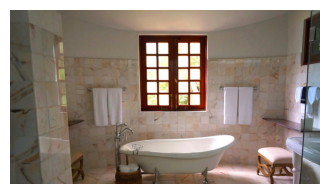

5120 2880
Tile(x_start=0, x_end=1024, y_start=0, y_end=1024, width=1024, height=1024)
Tile(x_start=819, x_end=1843, y_start=0, y_end=1024, width=1024, height=1024)
Tile(x_start=1638, x_end=2662, y_start=0, y_end=1024, width=1024, height=1024)
Tile(x_start=2457, x_end=3481, y_start=0, y_end=1024, width=1024, height=1024)
Tile(x_start=3276, x_end=4300, y_start=0, y_end=1024, width=1024, height=1024)
Tile(x_start=4096, x_end=5120, y_start=0, y_end=1024, width=1024, height=1024)
Tile(x_start=0, x_end=1024, y_start=618, y_end=1642, width=1024, height=1024)
Tile(x_start=819, x_end=1843, y_start=618, y_end=1642, width=1024, height=1024)
Tile(x_start=1638, x_end=2662, y_start=618, y_end=1642, width=1024, height=1024)
Tile(x_start=2457, x_end=3481, y_start=618, y_end=1642, width=1024, height=1024)
Tile(x_start=3276, x_end=4300, y_start=618, y_end=1642, width=1024, height=1024)
Tile(x_start=4096, x_end=5120, y_start=618, y_end=1642, width=1024, height=1024)
Tile(x_start=0, x_end=1024, y_start=12

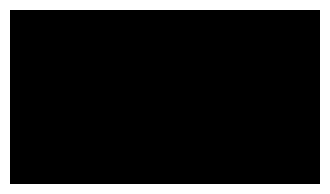

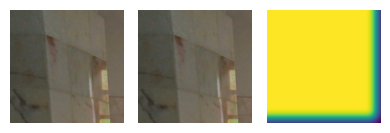

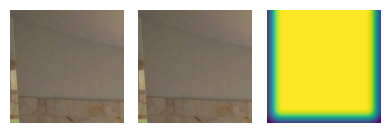

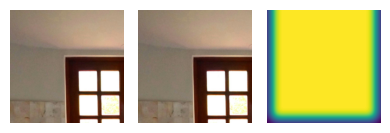

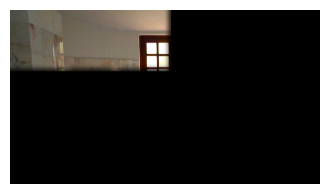

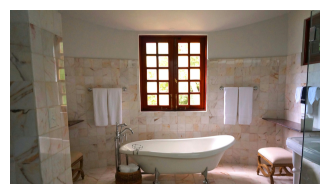

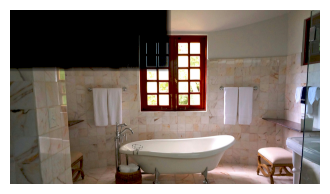

In [23]:
# Load input image
input_image = ImageUtils.load_image(r"E:\AI\images\places\bathroom_1280_720.png")
ImageUtils.plot_image(input_image, (4,4))

# Set scale factor and upscale size
scale_factor = 4
image_upscaled_width = scale_factor * input_image.width
image_upscaled_height = scale_factor * input_image.height
print(image_upscaled_width, image_upscaled_height)

# Set upscale tile size
tile_upscaled_width=1024
tile_upscaled_height=1024
min_tile_scaled_overlap=128

tiles_upscaled = TileCreator.from_min_overlap(
    image_upscaled_width,
    image_upscaled_height,
    tile_upscaled_width,
    tile_upscaled_height,
    min_tile_scaled_overlap
)

for tile_upscaled in tiles_upscaled.tiles:
    print(tile_upscaled)

tile_width = math.ceil(tile_upscaled_width / scale_factor)
tile_height = math.ceil(tile_upscaled_height / scale_factor)
print(tile_width, tile_height)

tiles = TileCreator(input_image.width, 
                    input_image.height, 
                    tile_width, 
                    tile_height, 
                    tiles_upscaled.num_tiles_width, 
                    tiles_upscaled.num_tiles_height)

for tile in tiles.tiles:
    print(tile)

feather_radius = 40
upscaled_tiled_image = Image.new('RGBA', (image_upscaled_width, image_upscaled_height), color='black')
ImageUtils.plot_image(upscaled_tiled_image, (4,4))


for index, (tile, tile_upscaled) in enumerate(zip(tiles.tiles, tiles_upscaled.tiles)):
    tile_image = tile.get_image_tile(input_image)
    tile_image_scaled = ImageUtils.upscale_image(tile_image, scale_factor)
    blending_mask = tile_upscaled.create_blending_mask_tile_space(upscaled_tiled_image, feather_radius)
    upscaled_tiled_image = tile_upscaled.compose_with_mask(upscaled_tiled_image, tile_image_scaled, feather_radius)

    ImageUtils.plot_images_grid([tile_image, tile_image_scaled, blending_mask], n_cols=3, n_rows=1, figsize=(4, 2))

    if index > 1:
        break

ImageUtils.plot_image(upscaled_tiled_image,(4,4))
upscaled_image = ImageUtils.upscale_image(input_image,scale_factor)
ImageUtils.plot_image(upscaled_image,(4,4))
image_diff = ImageUtils.image_diff_with_threshold(upscaled_tiled_image.convert('RGB'), upscaled_image.convert('RGB'))
ImageUtils.plot_image(image_diff, (4,4))

In [48]:
for tile in tiles_upscaled.tiles:
    print(tile)
    tile_image = tile.get_image_tile(image_upscaled)
    tile_mask = tile.create_blending_mask_target_image_space(image_upscaled, 40)
    rgb_tile_mask = tile.visualize_blending_mask(tile_mask)
    plot_image(rgb_tile_mask, (8,5))
    plot_image(tile_image, (3,3))

Tile(x_start=0, x_end=1024, y_start=0, y_end=1024, width=1024, height=1024)


NameError: name 'image_upscaled' is not defined

In [15]:
import torch
from PIL import Image
import numpy as np
from RealESRGAN import RealESRGAN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = RealESRGAN(device, scale=4)
model.load_weights('weights/RealESRGAN_x4.pth', download=True)

input_image = ImageUtils.load_image(r"E:\AI\images\places\bathroom_1280_720.png").convert('RGB')

sr_image = model.predict(input_image)

# sr_image.save('results/sr_image.png')

cuda


c:\Users\Admin\Documents\Code\airendering\stablediff_workflows\.venv\Lib\site-packages\RealESRGAN\model.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loadnet = torch.

In [8]:
sr_image.size

(5120, 2880)

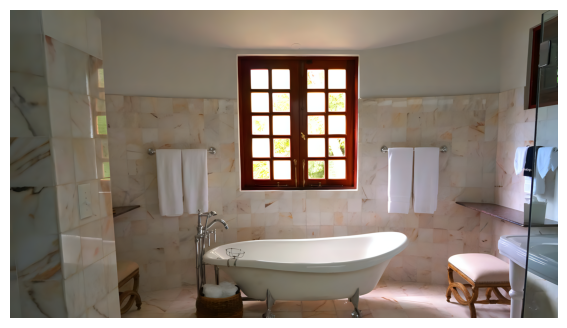

In [7]:
ImageUtils.plot_image(sr_image, (8,4))

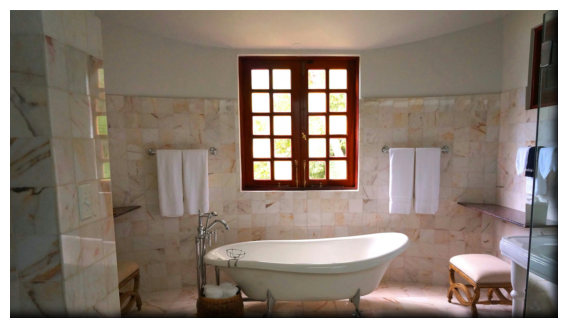

In [13]:
ImageUtils.plot_image(upscaled_tiled_image, (8,4))

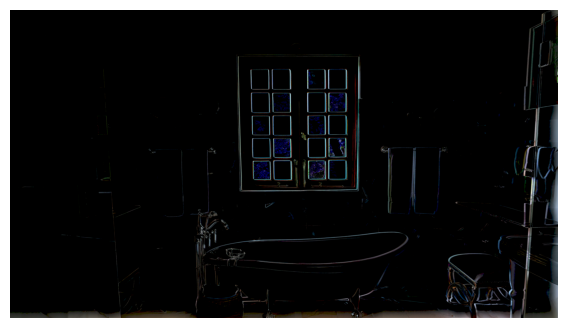

In [12]:
image_diff = ImageUtils.image_diff_with_threshold(upscaled_tiled_image.convert('RGB'), sr_image.convert('RGB'))
ImageUtils.plot_image(image_diff, (8,4))

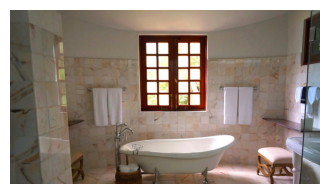

5120 2880
256 256


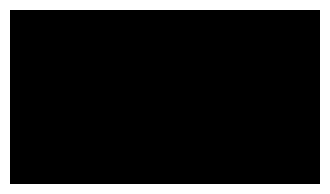

(5120, 2880)
(256, 256)
Tile(x_start=0, x_end=256, y_start=0, y_end=256, width=256, height=256)
Tile(x_start=0, x_end=1024, y_start=0, y_end=1024, width=1024, height=1024)


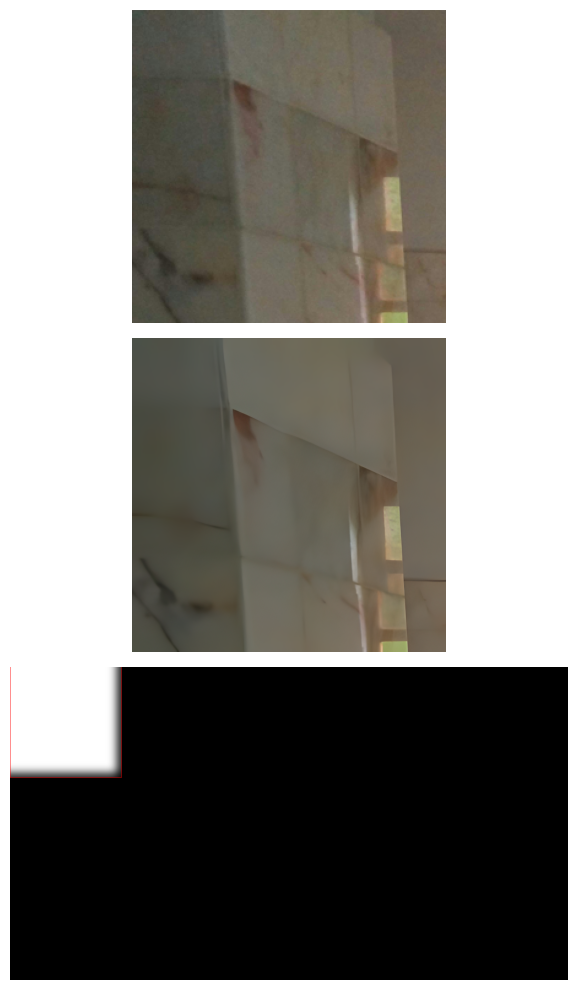

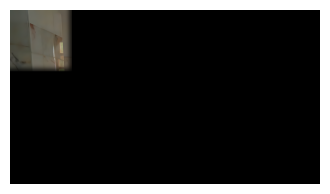

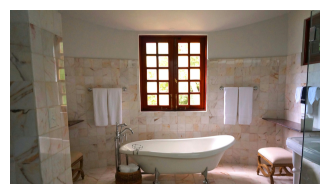

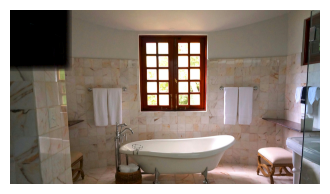

In [38]:
input_image = ImageUtils.load_image(r"E:\AI\images\places\bathroom_1280_720.png")
ImageUtils.plot_image(input_image, (4,4))
scale_factor = 4
image_upscaled_width = scale_factor * input_image.width
image_upscaled_height = scale_factor * input_image.height
print(image_upscaled_width, image_upscaled_height)

tile_upscaled_width=1024
tile_upscaled_height=1024
min_tile_scaled_overlap=128

tiles_upscaled = TileCreator.from_min_overlap(
    image_upscaled_width,
    image_upscaled_height,
    tile_upscaled_width,
    tile_upscaled_height,
    min_tile_scaled_overlap
)


tile_width = math.ceil(tile_upscaled_width / scale_factor)
tile_height = math.ceil(tile_upscaled_height / scale_factor)
print(tile_width, tile_height)

tiles = TileCreator(input_image.width, 
                    input_image.height, 
                    tile_width, 
                    tile_height, 
                    tiles_upscaled.num_tiles_width, 
                    tiles_upscaled.num_tiles_height)

feather_radius = 40
upscaled_tiled_image = Image.new('RGB', (image_upscaled_width, image_upscaled_height), color='black')
ImageUtils.plot_image(upscaled_tiled_image, (4,4))
print(upscaled_tiled_image.size)

for index, (tile, tile_upscaled) in enumerate(zip(tiles.tiles, tiles_upscaled.tiles)):
    tile_image = tile.get_image_tile(input_image)
    print(tile_image.size)
    print(tile)
    print(tile_upscaled)
    # tile_image_scaled = upscale_image(tile_image, scale_factor)
    tile_image_scaled = model.predict(tile_image.convert('RGB'))
    mask = tile_upscaled.create_blending_mask_target_image_space(upscaled_tiled_image, feather_radius)
    mask_rgb = tile_upscaled.visualize_blending_mask(mask)
    upscaled_tiled_image = tile_upscaled.compose_with_mask(upscaled_tiled_image, tile_image_scaled, feather_radius)

    ImageUtils.plot_images_grid([tile_image, tile_image_scaled, mask_rgb], n_cols=1, n_rows=3, figsize=(10, 10))

    if index == 0:
        break

    

ImageUtils.plot_image(upscaled_tiled_image,(4,4))
upscaled_image = ImageUtils.upscale_image(input_image,scale_factor)
ImageUtils.plot_image(upscaled_image,(4,4))
image_diff = ImageUtils.image_diff_with_threshold(upscaled_tiled_image.convert('RGB'), upscaled_image.convert('RGB'), threshold=10)
ImageUtils.plot_image(image_diff, (4,4))

In [22]:
len(tiles.tiles)
for index, tile in enumerate(tiles.tiles):
    print(index, tile)

0 Tile(x_start=0, x_end=256, y_start=0, y_end=256, width=256, height=256)
1 Tile(x_start=204, x_end=460, y_start=0, y_end=256, width=256, height=256)
2 Tile(x_start=408, x_end=664, y_start=0, y_end=256, width=256, height=256)
3 Tile(x_start=612, x_end=868, y_start=0, y_end=256, width=256, height=256)
4 Tile(x_start=816, x_end=1072, y_start=0, y_end=256, width=256, height=256)
5 Tile(x_start=1024, x_end=1280, y_start=0, y_end=256, width=256, height=256)
6 Tile(x_start=0, x_end=256, y_start=154, y_end=410, width=256, height=256)
7 Tile(x_start=204, x_end=460, y_start=154, y_end=410, width=256, height=256)
8 Tile(x_start=408, x_end=664, y_start=154, y_end=410, width=256, height=256)
9 Tile(x_start=612, x_end=868, y_start=154, y_end=410, width=256, height=256)
10 Tile(x_start=816, x_end=1072, y_start=154, y_end=410, width=256, height=256)
11 Tile(x_start=1024, x_end=1280, y_start=154, y_end=410, width=256, height=256)
12 Tile(x_start=0, x_end=256, y_start=308, y_end=564, width=256, height=

In [25]:
upscaled_tiled_image.save('4k_RealESRGAN_tiled.png')
sr_image.save('4k_RealESRGAN.png')
upscaled_image.save('4k_lazos.png')
image_diff.save('diff.png')

In [39]:
image_diff.save('diff.png')